In [13]:
import matplotlib.pyplot as plt
import sys
sys.path.append('../src')

from transformers import OneFormerProcessor, OneFormerForUniversalSegmentation, OneFormerConfig
from transformers.models.oneformer.image_processing_oneformer import load_metadata, prepare_metadata
from safetensors.torch import load_model, save_model
from ignite.metrics import *
from config import DATASET_DIR, CLASS_INFO_PATH, MAIN_PROJECT_DIR, GALAXY_MEAN, GALAXY_STD
from visual import *
from dataset import *
from utils import *

In [2]:
dataset = json.load(open(os.path.join(DATASET_DIR, "galaxy_train.json")))
dataset = list(dataset.values())

# Skip unannotated images
dataset = [a for a in dataset if a['regions']]

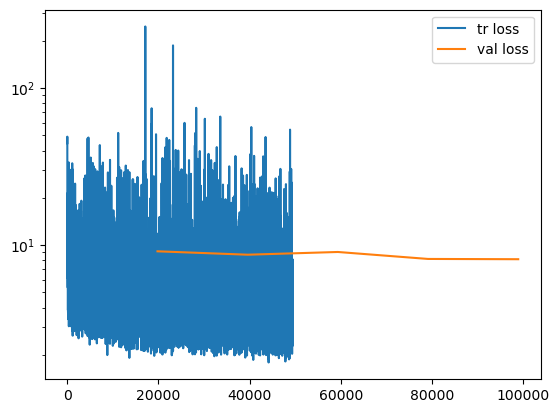

In [4]:
tr_loss = []
val_loss = []
with open("../out/tr_loss.txt", "r") as f:
    tr_loss = [float(val.split()[0]) for val in f.readlines()]

with open("../out/val_loss.txt", "r") as f:
    val_loss = [float(val.split()[0]) for val in f.readlines()]

plt.plot(tr_loss, label="tr loss")
x = [i for i in range(len(dataset), len(dataset)*6, len(dataset))]
plt.plot(x, val_loss, label="val loss")
plt.yscale("log", base=10)
plt.legend()


In [3]:
model_card = "shi-labs/oneformer_ade20k_swin_tiny"

id2label, label2id = get_id2label_mappings()
config = OneFormerConfig.from_pretrained(model_card, 
                                        num_classes = len(id2label),
                                        id2label = id2label,
                                        label2id = label2id,
                                        is_training=False)

model_seg = OneFormerForUniversalSegmentation.from_pretrained(model_card, config=config, ignore_mismatched_sizes=True)
model_seg_inst = OneFormerForUniversalSegmentation.from_pretrained(model_card, config=config, ignore_mismatched_sizes=True)

processor = OneFormerProcessor.from_pretrained(model_card)

# Metadata must be set according to the dataset through the class_info.json file. Background class must be specified as well. 
processor.image_processor.repo_path = MAIN_PROJECT_DIR
processor.image_processor.class_info_file = os.path.join(MAIN_PROJECT_DIR, CLASS_INFO_PATH)
processor.image_processor.metadata = prepare_metadata(load_metadata(MAIN_PROJECT_DIR, os.path.join(MAIN_PROJECT_DIR, CLASS_INFO_PATH)))
processor.image_processor.num_text = model_seg.config.num_queries - model_seg.config.text_encoder_n_ctx
processor.image_processor.do_resize = False
processor.image_processor.do_rescale = False

# strict = False because we don't need the text mapper at inference time
unmatched = load_model(model_seg, "../safetensors/galaxy_sem_5_1.safetensors", strict=False)
unmatched = load_model(model_seg_inst, "../safetensors/galaxy_sem_inst_10_2.safetensors", strict=False)

/home/panzaresce/anaconda3/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of OneFormerForUniversalSegmentation were not initialized from the model checkpoint at shi-labs/oneformer_ade20k_swin_tiny and are newly initialized because the shapes did not match:
- model.transformer_module.decoder.class_embed.weight: found shape torch.Size([151, 256]) in the checkpoint and torch.Size([7, 256]) in the model instantiated
- model.transformer_module.decoder.class_embed.bias: found shape torch.Size([151]) in the checkpoint and torch.Size([7]) in the model instantiated
- criterion.empty_weight: found shape torch.Size([151]) in the checkpoint and torch.Size([7]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use i

In [4]:
# Only the text_mapper should be unmatched with the pretrained model
for el in unmatched[1]:
    if el.split(".")[1] != "text_mapper":
        print(f"BAD: {el}")

In [5]:
dataset_test = GalaxyDataset(DATASET_DIR, "test", processor, CLASS_INFO_PATH, None, GALAXY_MEAN, GALAXY_STD, load_on_demand=True)
print(len(dataset_test))

2828


### Metrics on segmentation only

In [6]:
run_iou, run_dice, run_acc, confusion_matrix_seg = compute_metrics(dataset_test, model_seg, processor, len(id2label))
print(f"mIoU: {run_iou / len(dataset_test):.4f}")
print(f"Dice: {run_dice / len(dataset_test):.4f}")
print(f"Accuracy: {run_acc / len(dataset_test):.4f}")

Using task semantic
mIoU: 0.6218
Dice: 0.6539
Accuracy: 0.7019


In [7]:
map = compute_meanap(model_seg, processor, dataset_test, verbose=True)
print(f"AP (at IoU=.50:.05:.95) = {map:.4f}")

Using task instance
Threshold | per_class_AP
0.50 | {1: 0.5683186138780691, 2: 0.2862357423865051, 3: 0.5696313256068152, 4: 0.679565154536578, 5: 0.0}
0.55 | {1: 0.5683186138780691, 2: 0.2862357423865051, 3: 0.5696313256068152, 4: 0.679565154536578, 5: 0.0}
0.60 | {1: 0.5683186138780691, 2: 0.2862357423865051, 3: 0.567099753656644, 4: 0.6789798600115787, 5: 0.0}
0.65 | {1: 0.5683186138780691, 2: 0.2862357423865051, 3: 0.567099753656644, 4: 0.6789798600115787, 5: 0.0}
0.70 | {1: 0.5683186138780691, 2: 0.2862357423865051, 3: 0.567099753656644, 4: 0.6789798600115787, 5: 0.0}
0.75 | {1: 0.5652038426979837, 2: 0.2862357423865051, 3: 0.5650987850498244, 4: 0.6789798600115787, 5: 0.0}
0.80 | {1: 0.5609398908515202, 2: 0.2862357423865051, 3: 0.5633501406219366, 4: 0.6766376168764725, 5: 0.0}
0.85 | {1: 0.5565725784557928, 2: 0.27884542192257505, 3: 0.5601823209995717, 4: 0.6706880496102007, 5: 0.0}
0.90 | {1: 0.546206830248028, 2: 0.2145020278543006, 3: 0.5406243285244334, 4: 0.66524369155001

/home/panzaresce/repos/galaxy_segmentation/notebooks/../src/visual.py:149: RuntimeWarning: invalid value encountered in divide
  normalized_confusion_matrix = confusion_matrix / row_sums


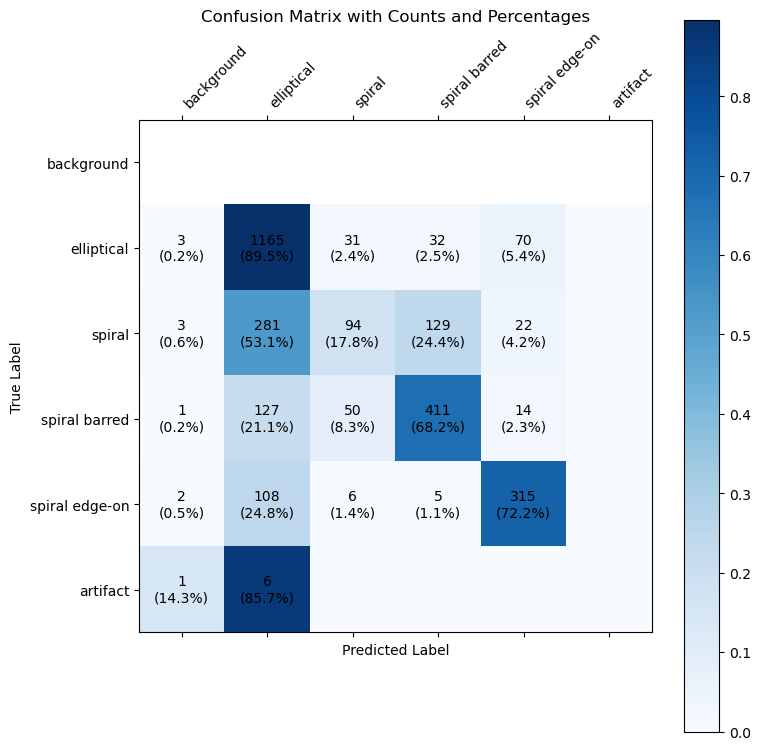

In [8]:
show_confusion_matrix(confusion_matrix_seg, id2label)

### Metrics on segmentation+instance

In [9]:
run_iou, run_dice, run_acc, confusion_matrix_seg_inst = compute_metrics(dataset_test, model_seg_inst, processor, len(id2label))
print(f"mIoU: {run_iou / len(dataset_test):.4f}")
print(f"Dice: {run_dice / len(dataset_test):.4f}")
print(f"Accuracy: {run_acc / len(dataset_test):.4f}")

Using task semantic
mIoU: 0.6399
Dice: 0.6726
Accuracy: 0.7118


In [10]:
map = compute_meanap(model_seg_inst, processor, dataset_test, verbose=True)
print(f"AP (at IoU=.50:.05:.95) = {map:.4f}")

Using task instance
Threshold | per_class_AP
0.50 | {1: 0.5643057690266122, 2: 0.27623593141454567, 3: 0.5317959203390301, 4: 0.5797823770979007, 5: 0.0}
0.55 | {1: 0.5634777444032552, 2: 0.20574837001395097, 3: 0.5222932656407676, 4: 0.5784961690645471, 5: 0.0}
0.60 | {1: 0.560291622328625, 2: 0.18383662975575651, 3: 0.429202878280322, 4: 0.5463192225456127, 5: 0.0}
0.65 | {1: 0.5507489506247623, 2: 0.08852413019079686, 3: 0.4109161889551806, 4: 0.4616806249532149, 5: 0.0}
0.70 | {1: 0.4605338102581872, 2: 0.028708133971291863, 3: 0.31902760617668524, 4: 0.27914104645528687, 5: 0.0}
0.75 | {1: 0.2838614082889664, 2: 0.013986013986013986, 3: 0.21271895628670928, 4: 0.059486166007905135, 5: 0.0}
0.80 | {1: 0.1166043259066515, 2: 0.0, 3: 0.04398826979472141, 4: 0.0027137042062415195, 5: 0.0}
0.85 | {1: 0.013986013986013986, 2: 0.0, 3: 0.003134796238244514, 4: 0.0008190008190008189, 5: 0.0}
0.90 | {1: 0.013986013986013986, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0}
0.95 | {1: 0.0, 2: 0.0, 3: 0.0, 4:

/home/panzaresce/repos/galaxy_segmentation/notebooks/../src/visual.py:149: RuntimeWarning: invalid value encountered in divide
  normalized_confusion_matrix = confusion_matrix / row_sums


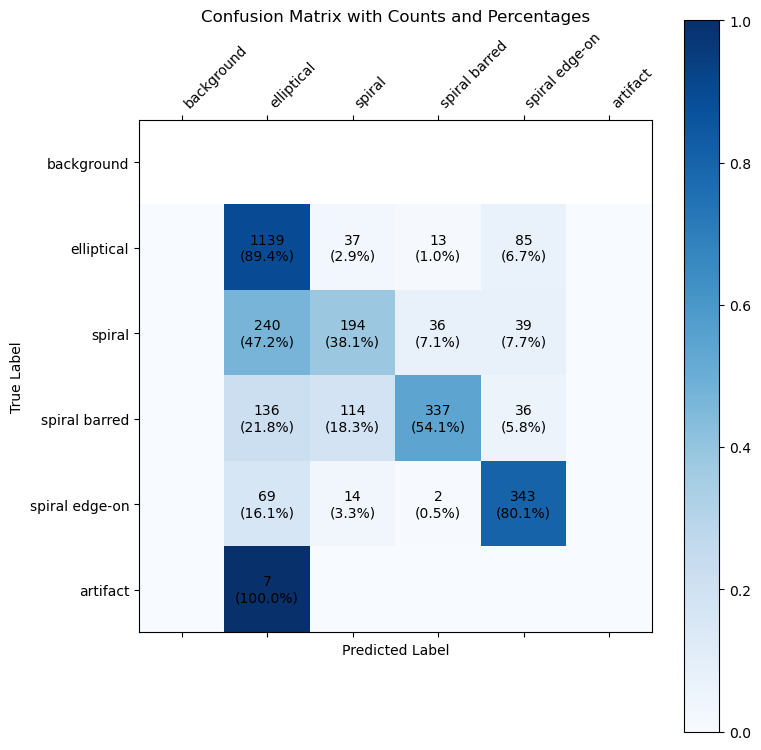

In [11]:
show_confusion_matrix(confusion_matrix_seg_inst, id2label)

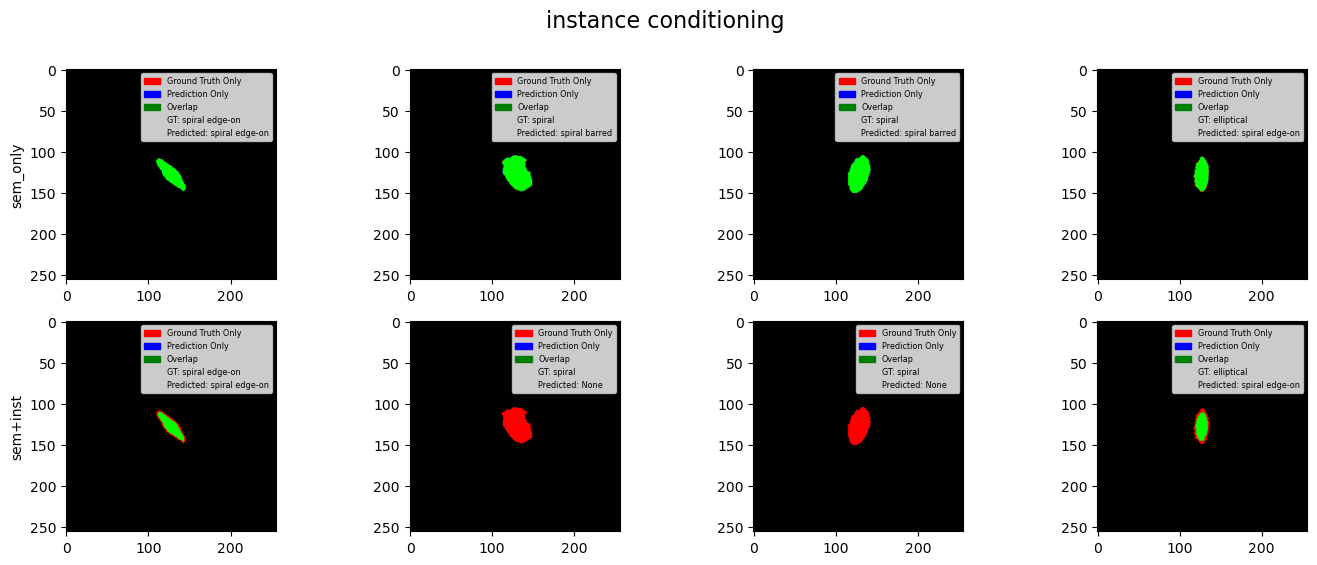

In [64]:
compare_models(model_seg, model_seg_inst, processor, dataset_test, id2label, "semantic", ("sem_only", "sem+inst"))

### Use model as a sliding window over bigger image

In [38]:
# path = "../astrocv_m.jpg"
path = "../mask_galaxy_bench.jpg"

# predictions = process_image(path, model, processor, 10, 0.5, 0.3)
task = "semantic"
all_chunks = run_sliding_windows_over_image(path, model_seg_inst, processor, 5, 0.5, 90, task)
predictions = nms(all_chunks, 0.3, task)

Sliding window...
21904 chunks being processed
426 objects detected
426 objects extracted
Performing NMS...
31 objects after NMS


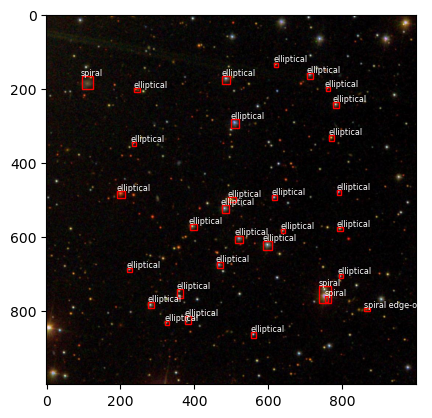

In [39]:
import matplotlib.patches as patches

fig, ax = plt.subplots()
image = skimage.io.imread(path)
ax.imshow(image)


for pred in predictions:
    xmin, ymin, w, h = extract_bounding_box(pred["mask"], pred["pos"])
    # print(xmin, ymin, w, h)
    ax.add_patch(patches.Rectangle((xmin, ymin), w, h, linewidth=1, edgecolor='r', facecolor='none'))
    label = "/".join([id2label[l.item()] for l in pred["mask"][pred["mask"] != 0].unique()])
    ax.text(xmin-2, ymin-2, label, c="w", fontsize="xx-small")

plt.show()

### Comparison of the two models over off-centered image

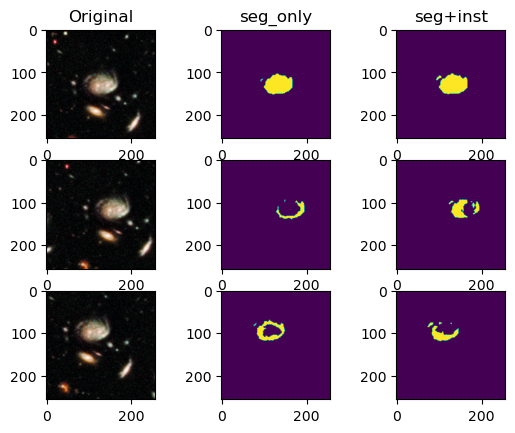

In [34]:
centered_si = run_model_on_image(model_seg_inst, processor, "../astrocv_xs_1_c.jpg", "semantic")
right_si = run_model_on_image(model_seg_inst, processor, "../astrocv_xs_1_cr.jpg", "semantic")
bot_si = run_model_on_image(model_seg_inst, processor, "../astrocv_xs_1_ct.jpg", "semantic")

centered_s = run_model_on_image(model_seg, processor, "../astrocv_xs_1_c.jpg", "semantic")
right_s = run_model_on_image(model_seg, processor, "../astrocv_xs_1_cr.jpg", "semantic")
bot_s = run_model_on_image(model_seg, processor, "../astrocv_xs_1_ct.jpg", "semantic")


fig, axs = plt.subplots(3,3)
axs[0, 0].set_title("Original")
axs[0, 1].set_title("sem_only")
axs[0, 2].set_title("sem+inst")

axs[0, 0].imshow(skimage.io.imread("../astrocv_xs_1_c.jpg"))
axs[0, 1].imshow(centered_s.squeeze().cpu())
axs[0, 2].imshow(centered_si.squeeze().cpu())

axs[1, 0].imshow(skimage.io.imread("../astrocv_xs_1_cr.jpg"))
axs[1, 1].imshow(right_s.squeeze().cpu())
axs[1, 2].imshow(right_si.squeeze().cpu())

axs[2, 0].imshow(skimage.io.imread("../astrocv_xs_1_ct.jpg"))
axs[2, 1].imshow(bot_s.squeeze().cpu())
axs[2, 2].imshow(bot_si.squeeze().cpu())

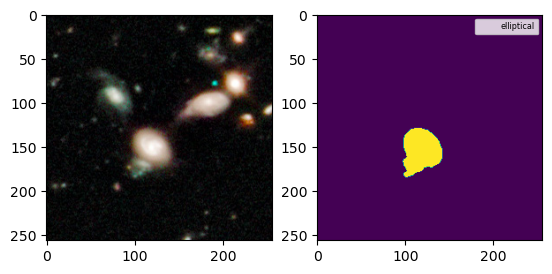

In [59]:
path = "../astrocv_0.jpg"
mask = run_model_on_image(model_seg, processor, path, "instance")

fig, axs = plt.subplots(1,2)
axs[0].imshow(skimage.io.imread(path))
axs[1].imshow(mask.cpu().squeeze())
axs[1].legend(handles=[Patch(fill=False, edgecolor='none', label=id2label[mask[mask != 0].unique().item()])], loc='upper right', fontsize='xx-small')